# Insights into Magnetic Resonance Imaging

## Simulation of a Spin Ensemble and a Spin Echo Experiment

First we import the required libraries.

In [1]:
import sys
import numpy as np
import cmath
import math
import matplotlib.pyplot as plt

We remember how we can use matplotlib to plot a graph into our Jupyter Notebook.
Here an example on how to plot a linear graph supported by 4 points.
Remember that the index in Python starts with zero.

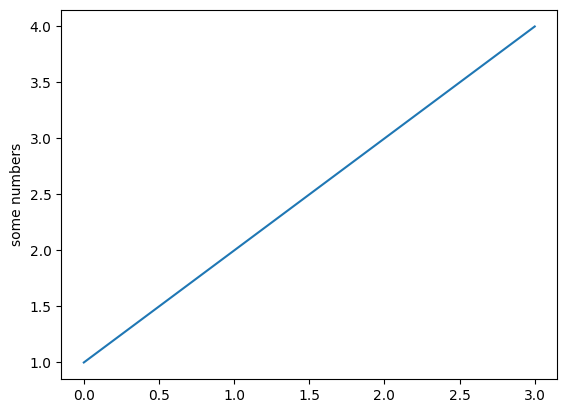

In [2]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

## The Vector Class

Some linear algebra is required. Here, we provide functionality for three-dimensional vectors.
It is possible to rotate the vectors around the x-axis and z-axis.

- Rotation around the z-axis
This is used to represent precession. Any vector that is tiltet against the z-axis will precess at the Larmor frequency.
So this is happening without any radiofrequency pulses being applied.

- Rotation around the x-axis
This is simulating a radiofrequency (RF)-pulse applied along the x-axis. Using such a pulse, the magnetization can be modified. For a system in equilibrium, the entire z-magnetization is aligned along the z-axis. So, a RF pulse can be used to bring the magnetization out of equilibrium.

In [33]:
class Vector:
    def __init__(self, x, y, z):
        self.value = np.array([x,y,z])
        self.precision_digits=8
    def rotatez(self, angle):
        rotmatz = np.array([[    math.cos(angle), -math.sin(angle), 0.0],
                                [math.sin(angle), math.cos(angle), 0.0],
                                [0.0, 0.0, 1.0]
                        ])
        self.value = np.dot(rotmatz, self.value)
        return self
    def rotatex(self, angle):
        rotmatz = np.array([   [1.0, 0.0, 0.0],
                            [  0.0, math.cos(angle), -math.sin(angle)],
                                [0.0, math.sin(angle), math.cos(angle)],
                                
                        ])
        self.value = np.dot(rotmatz, self.value)
        return self    
    def print(self):
        print(self.toString())
    def toString(self):
        return f"({self.value[0]}, {self.value[1]}, {self.value[2]})"
    def mult(self, factor):
        self.value = self.value * factor
        return self
    def add(self, summand):
        self.value = self.value + summand.value
        return self   
    def norm(self):
        return np.linalg.norm(self.value) 
    def round(self):
        self.value = np.around(self.value, decimals=self.precision_digits) 
        return self
    def projectxy(self):
        return Vector(self.value[0], self.value[1], 0.0)

### Let's try out the Vector Class:

We can instantiate a **Vector Object** by using the constructor:

`v = Vector(0,0,1)` creates one Vector with x,y,z = (0,0,1)

If we rotate this vector around the x-axis, the vector length does not change.
Vector length is the **vector norm**

You see that the vector norm does not change no matter by which amount you rotate the vector around the x- or z-axes.

In [36]:
v = Vector(0,0,1)
print(f"Freshly instantiated vector object {v.toString()}")
print(f"Vector norm is {v.norm()}")

v.rotatex(np.deg2rad(45)).round()
print(f"Vector after rotation {v.toString()}")
print(f"Vector norm is {round(v.norm(), ndigits = 8)}")

v.rotatez(np.deg2rad(45)).round()
print(f"Vector after rotation {v.toString()}")
print(f"Vector norm is {round(v.norm(), ndigits = 8)}")

v.rotatez(np.deg2rad(135)).round()
print(f"Vector after rotation {v.toString()}")
print(f"Vector norm is {round(v.norm(), ndigits = 8)}")

v.rotatex(np.deg2rad(135)).round()
print(f"Vector after rotation {v.toString()}")
print(f"Vector norm is {round(v.norm(), ndigits = 8)}")

Freshly instantiated vector object (0, 0, 1)
Vector norm is 1.0
Vector after rotation (0.0, -0.70710678, 0.70710678)
Vector norm is 1.0
Vector after rotation (0.5, -0.5, 0.70710678)
Vector norm is 1.0
Vector after rotation (0.0, 0.70710678, 0.70710678)
Vector norm is 1.0
Vector after rotation (0.0, -1.0, 0.0)
Vector norm is 1.0


There is a little trick involved here, to make the output look better.
There are rounding errors in any computation using floating point numbers. 
Floating point numbers are the way the computer represents the decimal digits of numbers. As there is only limited space and specifically in trigonometric functions like sine and cosine infinite decimals occur, rounding errors must occur.
For this example, we repeatedly call the `round` function of the class, to remove the small rounding errors.

## Exercise:
Change the rotation angles above and the vector itself and observe the effects.
You may add more rotations or simplify to less rotations.
Try negative rotations.
Use a real world object like a pen and paper drawings to understand the way the rotations work.

## Exercise:
Try out other functions of the vector class, such as `projectxy`, which gives the vector projected onto the x/y-plane.

## The Spin Class

We will now utilize the *Vector Class* to implement a **Spin Class**.
This class will represent some properties of a small **spin**. A spin is the smallest component of the MRI experiment that we are simulating. Everything we do in the next steps will result in changes to the spin objects. Every single spin object holds a specific state of a spin that it represents. By later using many spin objects at once, we can manipulate them in different ways and store the information in a large set of many spin objects.

But before we do that, we need to define what one single spin needs to know about itself:

* It should know the precession frequency. While in the big perspective, all spins precess about at the **Larmor Frequency**, which is approximately **64 MHz at 1.5 Tesla**, there are frequency shifts that individual spins experience that lower or increase the local Larmor Frequency by a few **parts per million (ppm)**. Such small frequency shifts can be deliberate, e.g. by applying external gradient fields, but thay can also be a property of the matter itself, e.g. caused by susceptibility differences between different tissue components. So, each spin stores its current precession frequency in a class variable called `frequency`. Recall that class variables are referenced by adding the `self` object, e.g. `self.frequency` refers to the class variable `frequency` of the current object.

* It knows its magnitude. That is the vector norm. Note that when the object is instantiated in the `__init__` function. A unit vector, i.e. a vector of magnitude one, is created along the z-axis and multiplied by the magnitude, resulting in a vector of the desired magnitude.

### Exercise:
Experiment with the vector norm function in the previous example (where you rotated vectors), by instantiating unit vectors, multiplying them and checking the resulting norm and the stability of this norm under rotation.


In [ ]:
# Use this space to experiment, you may want to copy some code from above


* It also holds information about its Vector Object. In a sense, a Spin Object is mainly a Vector Object, but it allows some operations that are not basic Vector operations but specific to Spins.

* It provides several functions that make sense to be applied to a Spin Object:

    * Precession: Precession is what happens to a spin in a magnetic field automatically over time. 

    ### Exercise:
    Read through the `precess(self, time_msec)` function and try to understand what it does.
    <details>
        <summary>Answer</summary>
        It divides the time given in milliseconds by 1000, to obtain the time in seconds.
        It then calculates the radians of a full rotation of 2*pi and multiplies that by the previous result.
        This gives the amount of rotation in radians that occurs in one second if the frequency is 1 Hertz.
        We then multiply by `self.frequency` to obtain the rotations at this frequency.
    </details>

* It also provides a possibility to be rotated around the x-axis. Here, the angle in radians is provided as an argument directly.

In [37]:
class Spin:
    def __init__(self, frequency, magnitude):
        self.frequency = frequency
        self.magnitude = magnitude
        self.vector = Vector(0.0, 0.0, 1.0).mult(magnitude);
    def getFrequency(self):
        return self.frequency
    def precess(self, time_msec):
        angle = ((time_msec/1000)*2.0*math.pi)*self.frequency
        #print(f"angle = {angle}")
        self.vector = self.vector.rotatez(angle)
    def print(self):
        print(f"Frequency = {self.frequency}, vector = {self.vector.toString()}, magnitude = {self.magnitude}")
    def magnitude(self):
        return np.norm(self.vector.projectxy())    
    def reset(self):
        self.vector = Vector(0.0, 0.0, self.vector.norm())  
    def rotatex(self, angle):
        self.vector = self.vector.rotatex(angle)

## The Spin Ensemble Class

This class now collects many spins into one unit called a **spin ensemble**.
A *spin ensemble* is thus a collection of many spins. How many can be provided to the constructor as an argument `number_spins`.

The constructor also takes the arguments `offset_frequency` and `stdev_offset`, which are used to generate a Gaussian distribution of Spin frequencies within the ensemble with mean and standard deviation according to these parameters.

The result is a collection of many Spin Objects, all with different frequencies.

One can calculate a magnitude for the entire ensemble, which is the vector sum of all spins in the ensemble.

### Exercise:
Read through the following Class definition and try to understand what the Class Functions do, and why they may be needed.

In [38]:
class Spinensemble:
    
    def __init__(self, number_spins, offset_frequency, stdev_offset):
        magnitude = 2.0
        self.spin_array = [ Spin(freq, magnitude) for freq in np.random.normal(offset_frequency, stdev_offset, number_spins)]
    def precess(self, time_msec):
        for spin in self.spin_array:
            spin.precess(time_msec)
    def magnitude(self):
        res = Vector(0.0,0.0,0.0)
        for spin in self.spin_array:
            res=res.add(spin.vector)
        return res.norm()
    def magnitudeAfterPrecession(self,time_msec):     
        self.precess(time_msec)      
        return self.magnitude
    def invert(self):
        for spin in self.spin_array:
            spin.frequency = -spin.frequency
    def phase_reset(self):
        for spin in self.spin_array:
            spin.reset()
    def x_pulse(self, angle_in_deg):
        for spin in self.spin_array:
            spin.rotatex(np.deg2rad(angle_in_deg))   

### Exercise:
Instantiate a Spinensemble Class Object and use the class functions to manipulate the magnetization, print your results and try to understand why the output changes in the way it does under these manipulations:

In [ ]:
# Experiment here

<details>
<summary>Example Code and Some Useful Constants</summary>
The following code may be useful for you to experiment

Note that some reasonable values for a typical spin ensemble setup are provided in the section of constants at the top. E.g. a Larmor Frequency of 64 MHz, modeling a 1.5 Tesla MRI system.
   
```python
number_spins = 1000
larmor_frequency = 64.0e6 #Hz
offset_frequency = 4.7e-6 * larmor_frequency
stdev_offset = 0.2e-6 * larmor_frequency
stdev_larmor = 0.2e-6 #ppm

print(f"offset_frequency = {offset_frequency}, stdev_offset = {stdev_offset}")

# spin = Spin(offset_frequency+stdev_offset, 2.0)
# spin.print()
# spin.precess(1)
# spin.print()
# #1.0/larmor_frequency = 1.5625e-08

spins = Spinensemble(number_spins, offset_frequency, stdev_offset)

print(spins.magnitude())
spins.x_pulse(90)
spins.precess(10)
print(spins.magnitude())`
```
</details>

## A Spin Echo Experiment on a Spin Ensemble

Now that you have experimented with the Classes **Vector**, **Spin** and **Spinensemble**, you might have the impression that it is far to go to simulate an MRI experiment to gain some interesting insights from.
However, the next code example shows that we can now utilize the mentioned classes to provide a spin echo experiment and follow the magnetization of the spin ensemble over time graphically.

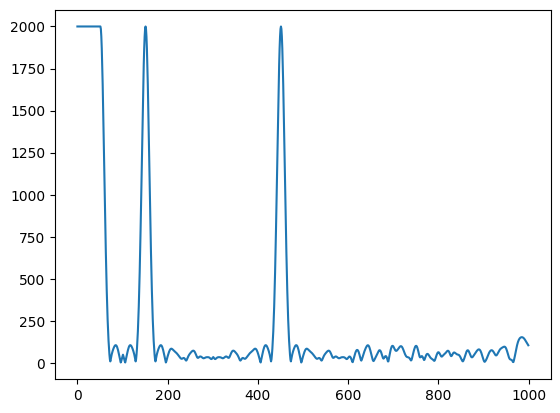

In [39]:
number_spins = 1000
larmor_frequency = 64.0e6 #Hz
offset_frequency = 4.7e-6 * larmor_frequency
stdev_offset = 0.3e-6 * larmor_frequency
stdev_larmor = 0.2e-6 #ppm

spins = Spinensemble(number_spins, offset_frequency, stdev_offset)

spins.phase_reset()
signal_over_time = []
for i in range (1000):
    signal_over_time.append(spins.magnitude())
    spins.precess(1)
    if i==50:
        spins.x_pulse(90)
    if i==100 or i==300:
        spins.invert()
#signal_over_time
plt.plot(signal_over_time)
# plt.ylabel('some numbers')
# plt.show()